# Style transfer using graph cuts

reimplementation of the paper : https://arxiv.org/pdf/1904.04443.pdf

Antoine Debouchage, Thomas Lemercier, Gaspard Berthelier

## Imports

In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

# %cd /content/drive/MyDrive/GRM_proj/

import os
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../..")

In [2]:
# !pip install PyMaxflow
# !pip install igraph

In [3]:
from PIL import Image
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from time import perf_counter

In [4]:
from src.energy import style_transfer
import src.graph_cut as gc
from maxflow.fastmin import aexpansion_grid

## Data

Content shape :  (512, 512, 3)
Style shape :  (512, 512, 3)


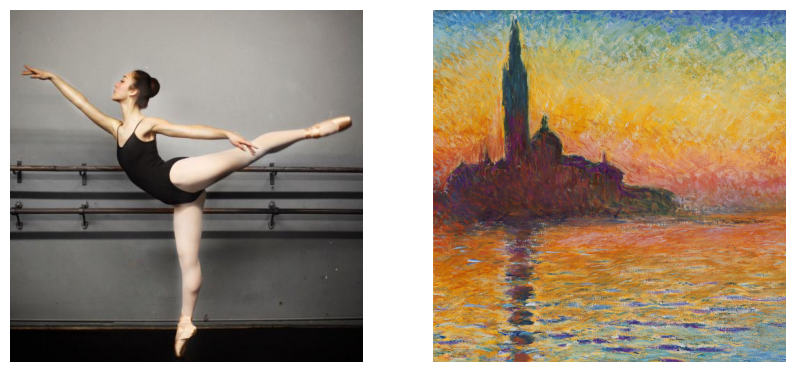

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name, for_plot=True):
    image = Image.open(image_name)
    image =  loader(image).unsqueeze(0).to(device, torch.float)[:, :3][0]
    if for_plot:
      image = image.cpu().numpy().transpose(1,2,0)
    return image


content_img = image_loader("../data/images/dance2.png")
style_img = image_loader("../data/images/monnet.png")

print("Content shape : ",content_img.shape)
print("Style shape : ",style_img.shape)


def plot_2_images(content, style):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(content)
    ax[0].axis('off')
    ax[1].imshow(style)
    ax[1].axis('off')
    plt.show();

plot_2_images(content_img,style_img)

content_features (3, 512, 512)
cluster_centers (3, 3)
data_term (512, 512, 3)


c:\Users\Antoine\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Antoine\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Transfered features shape :  torch.Size([3, 512, 512])


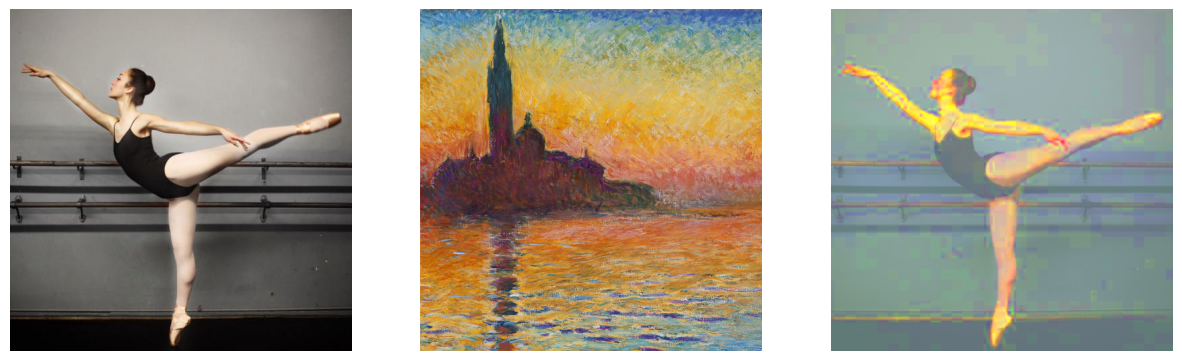

In [6]:
def plot_3_images(target, initial, assigned):
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(target)
    ax[0].axis('off')
    ax[1].imshow(initial)
    ax[1].axis('off')
    ax[2].imshow(assigned)
    ax[2].axis('off')
    plt.show();

#style transfer
transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=1, lambd=1, k=3)
print("Transfered features shape : ",transfered_features.shape)
plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())

Distance array shape :  (3, 512, 512)
Greedy assignments shape :  (512, 512)
Distance image shape :  (512, 512)


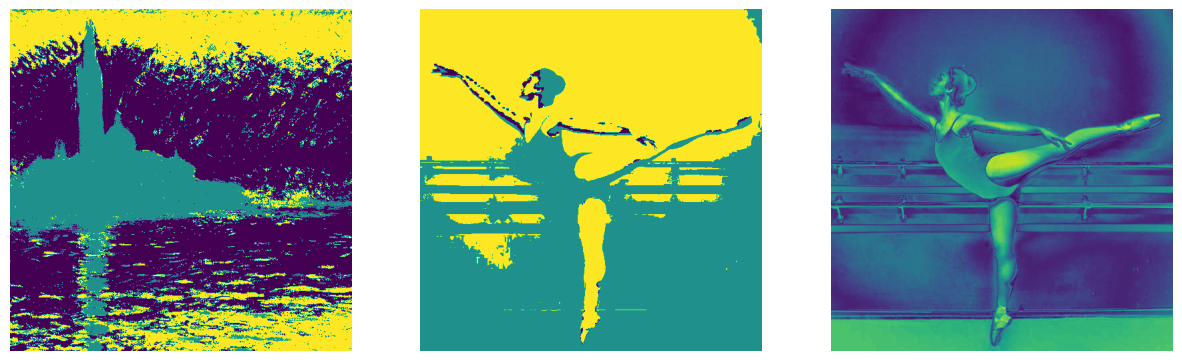

In [7]:
#clustering of style image
n_clusters=3

from sklearn.cluster import KMeans

style_img_flat = style_img.reshape((-1,3))
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(style_img_flat)

cluster_labels = kmeans.labels_.reshape((imsize,imsize))
cluster_centers = kmeans.cluster_centers_

# distance of content image to cluster centers

distance_array = np.zeros((n_clusters,imsize,imsize), dtype=np.float32)
print("Distance array shape : ",distance_array.shape)

for i, cluster_center in enumerate(cluster_centers):
    distances = np.linalg.norm(content_img - cluster_center, axis=2)
    distance_array[i] = distances


#greedy assignement
greedy_assignments = np.argmin(distance_array,axis=0)
print("Greedy assignments shape : ",greedy_assignments.shape)
distance_img = np.zeros((imsize,imsize),dtype=np.float32)
print("Distance image shape : ",distance_img.shape)

for i, cluster_center in enumerate(cluster_centers):
    mask = (greedy_assignments == i)
    distance_img[mask] = distance_array[i][mask]

plot_3_images(cluster_labels, greedy_assignments, distance_img)

Content feature shapes :  (262144, 3)
Cluster centers shape :  (3, 3)
Similarity shape :  (512, 512, 3)
Distance array shape :  (512, 512, 3)
Greedy assignments shape :  (512, 512)
Distance image shape :  (512, 512)
(512, 512) 4645
(512, 512) 43534
(512, 512) 213965


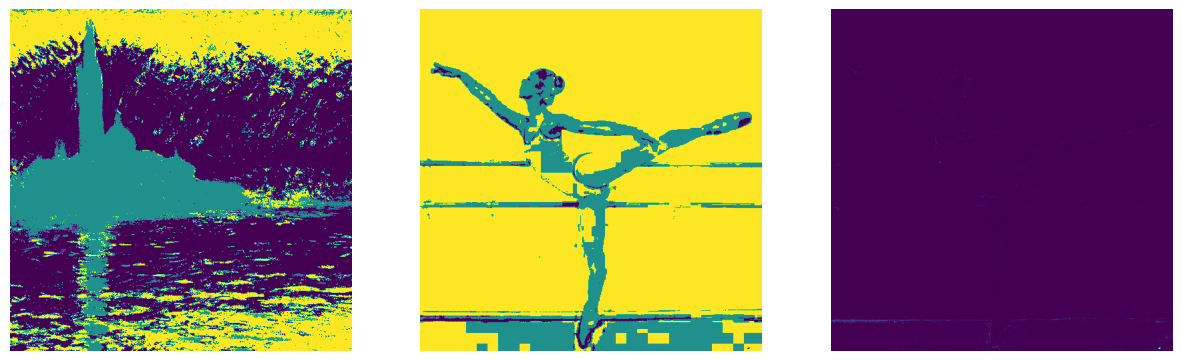

In [8]:
# distance of content image to cluster centers

from sklearn.metrics.pairwise import cosine_similarity

content_shape = content_img.transpose(2,0,1).shape # (channel, height, width)
content_features = content_img.transpose(2,0,1).reshape(content_shape[0], -1).T # (height * width, channel)

print("Content feature shapes : ",content_features.shape)
print("Cluster centers shape : ",cluster_centers.shape)
similarity = cosine_similarity(content_features, cluster_centers)
similarity = similarity.reshape(content_shape[1], content_shape[2], -1)
print("Similarity shape : ",similarity.shape)

cosine_distance_array = 1 - similarity
# cosine_distance_array = cosine_distance_array.transpose(2,0,1)
print("Distance array shape : ",cosine_distance_array.shape)

#greedy assignement
cosine_greedy_assignments = np.argmin(cosine_distance_array,axis=2)
print("Greedy assignments shape : ",cosine_greedy_assignments.shape)
cosine_distance_img = np.zeros((imsize,imsize),dtype=np.float32)
print("Distance image shape : ",cosine_distance_img.shape)

cosine_distance_array = cosine_distance_array.transpose(2,0,1)
for i, cluster_center in enumerate(cluster_centers):
    mask = (cosine_greedy_assignments == i)
    print(mask.shape, np.sum(mask))
    cosine_distance_img[mask] = cosine_distance_array[i][mask]

plot_3_images(cluster_labels, cosine_greedy_assignments, cosine_distance_img)

Content feature shapes :  (3, 512, 512)
Style feature shapes :  (3, 512, 512)
Cluster centers shape :  (3, 3)

Distance :  euclidean
Content feature shapes :  (3, 512, 512)
Cluster centers shape :  (3, 3)
Data term shape:  (512, 512, 3)
Greedy assignments shape :  (512, 512)
Distance image shape :  (512, 512)
mask shape:  (512, 512)


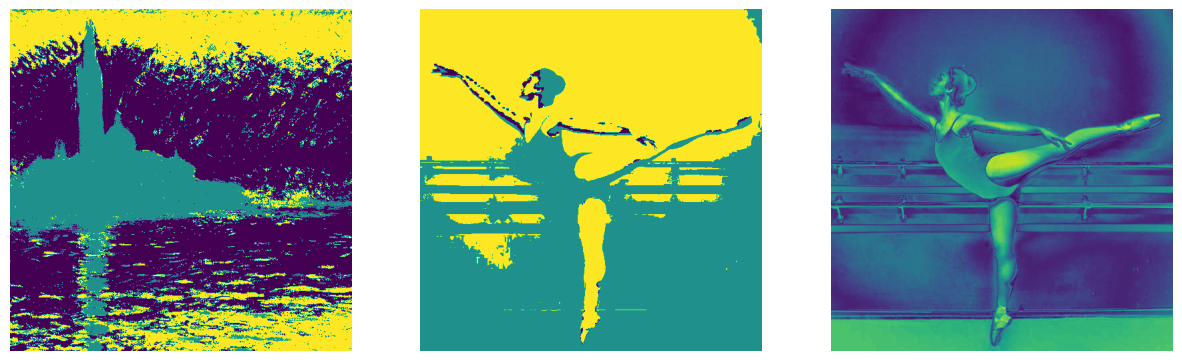


Distance :  cosine
Content feature shapes :  (3, 512, 512)
Cluster centers shape :  (3, 3)
Data term shape:  (512, 512, 3)
Greedy assignments shape :  (512, 512)
Distance image shape :  (512, 512)
mask shape:  (512, 512)


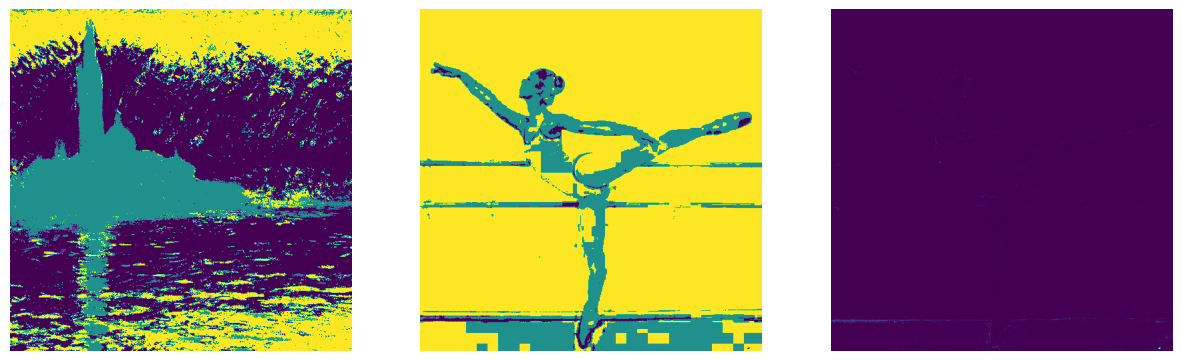

In [9]:
from src.energy import data_energy, cluster_style

content_img = image_loader("../data/images/dance2.png")
style_img = image_loader("../data/images/monnet.png")

content_features = content_img.transpose(2,0,1)
content_shape = content_features.shape # (channel, height, width)
style_features = style_img.transpose(2,0,1)
print("Content feature shapes : ",content_features.shape)
print("Style feature shapes : ",style_features.shape)
cluster_centers, cluster_list, cluster_labels = cluster_style(style_features, k = n_clusters)
print("Cluster centers shape : ",cluster_centers.shape)


for distance in ["euclidean","cosine",]:
  print("")
  print("Distance : ",distance)

  data_term = data_energy(content_features, cluster_centers, distance=distance)
  print("Data term shape: ",data_term.shape)

  greedy_assignments = np.argmin(data_term,axis=2)
  print("Greedy assignments shape : ",greedy_assignments.shape)

  distance_img = np.zeros((imsize,imsize),dtype=np.float32)
  print("Distance image shape : ",distance_img.shape)

  for i, cluster_center in enumerate(cluster_centers):
      mask = (greedy_assignments == i)
      if i==0: print("mask shape: ",mask.shape)
      distance_img[mask] = data_term[mask][:,i]

  plot_3_images(cluster_labels.reshape((imsize,imsize)), greedy_assignments, distance_img)

## Alpha expansion

In [16]:
#stochastic expansion

lambd = 1
max_iter = 1000

assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_stochastic(distance_array.transpose(1,2,0), greedy_assignments, max_iter=max_iter, lambd=lambd)

print("Mean number of fails : ",np.mean(fail_counts))

plot_2_images(greedy_assignments, assignments)
gc.plot_energy(energies, computed_energies, fail_counts)

Initial energy :  329530.784892695


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Initial energy :  5151.8757783174515


  0%|          | 0/1000 [00:00<?, ?it/s]

Final energy :  5142.015831112862
Mean number of fails :  124.125


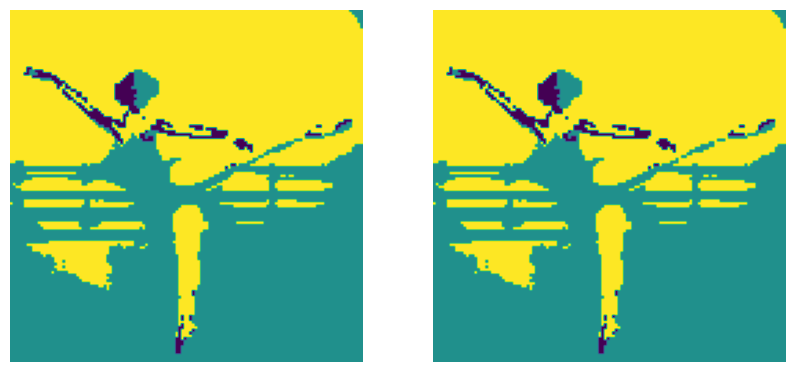

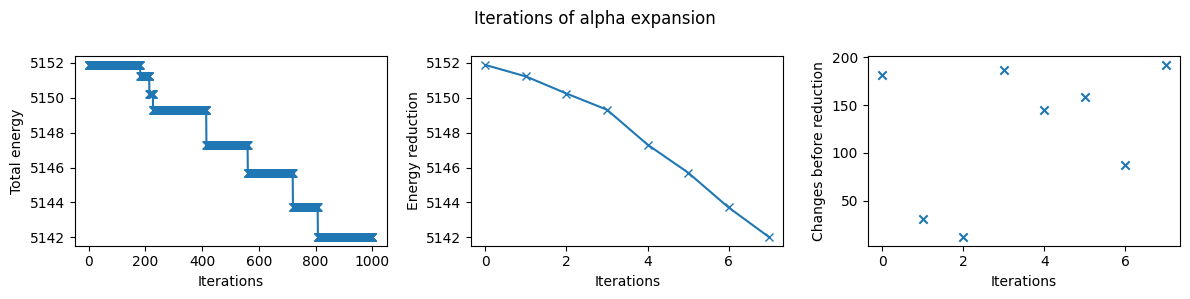

In [ ]:
#greedy expansion

lambd = 1
max_iter = 1000

assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_greedy(distance_array.transpose(1,2,0), greedy_assignments, max_iter=max_iter, lambd=lambd)

print("Mean number of fails : ",np.mean(fail_counts))

plot_2_images(greedy_assignments, assignments)
gc.plot_energy(energies, computed_energies, fail_counts)


lambda :  0.01


  0%|          | 0/30 [00:00<?, ?it/s]

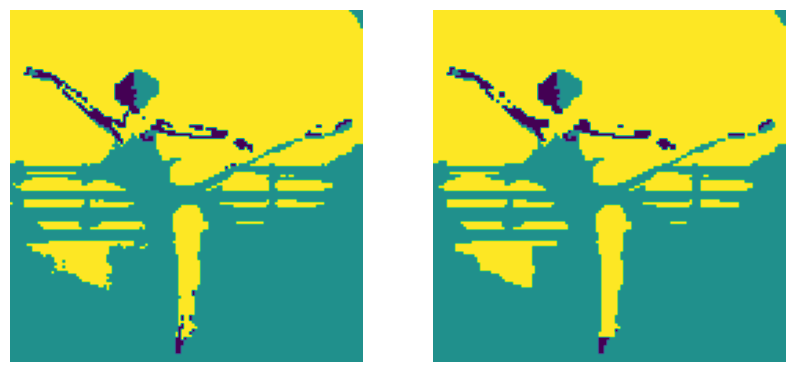

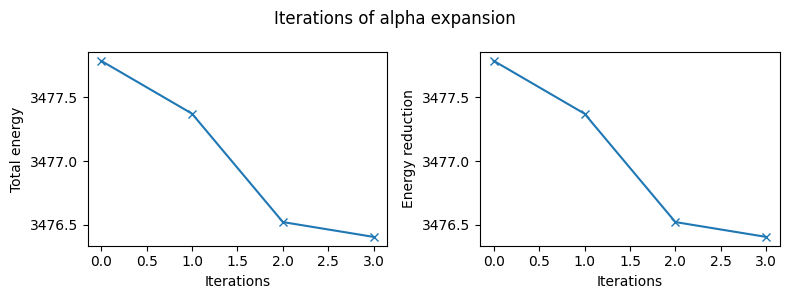


lambda :  0.1


  0%|          | 0/30 [00:00<?, ?it/s]

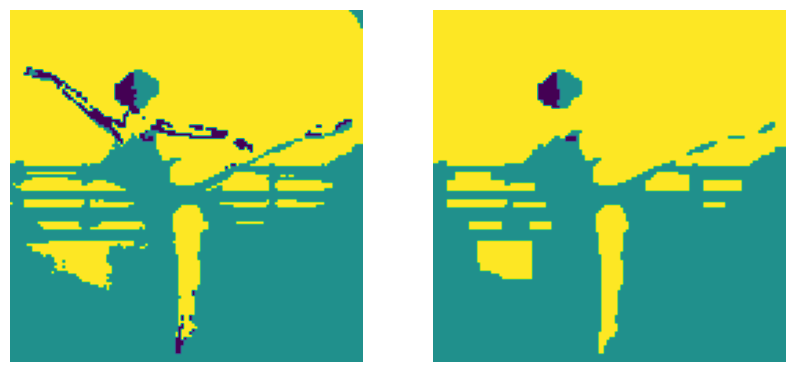

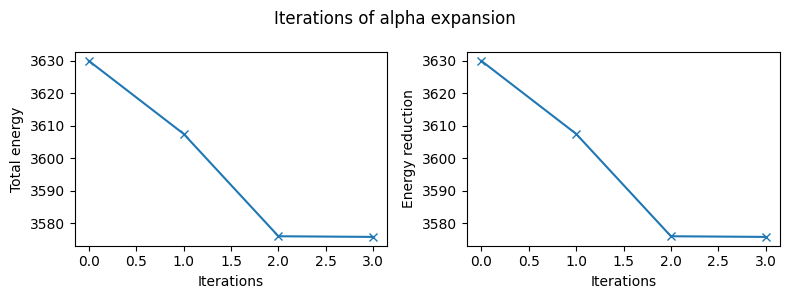


lambda :  1


  0%|          | 0/30 [00:00<?, ?it/s]

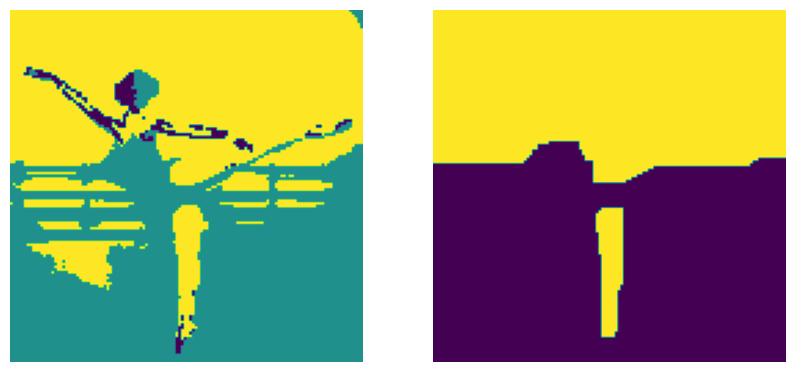

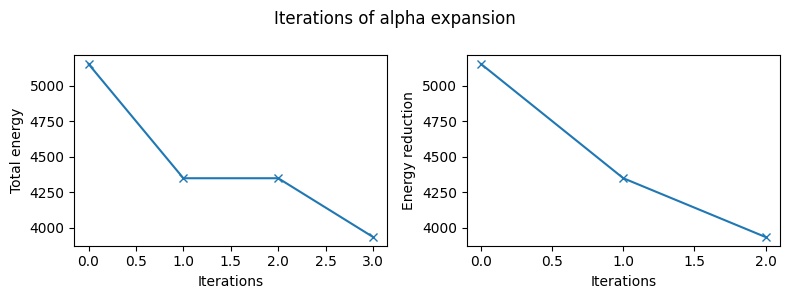

In [ ]:
#our own alphaexpansion

for lambd in [1e-2,1e-1,1]:
  print("")
  print("lambda : ", lambd)

  assignments, energies, computed_energies = gc.alpha_expansion(distance_array.transpose(1,2,0), greedy_assignments, max_cycles=10, lambd=lambd)

  plot_2_images(greedy_assignments, assignments)
  gc.plot_energy(energies, computed_energies)


lambda :  0.01
Done in 0.23061810000000094 s


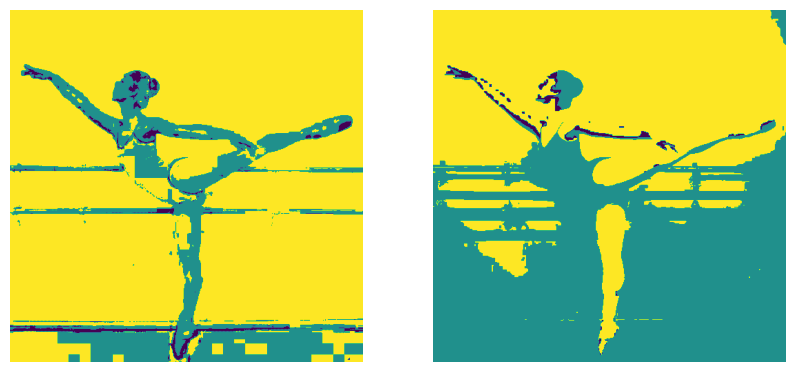


lambda :  0.1
Done in 0.44066409999999223 s


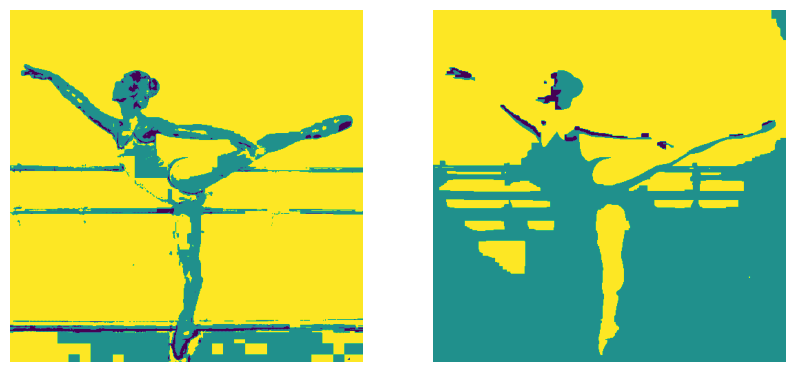


lambda :  1
Done in 0.3570153000000005 s


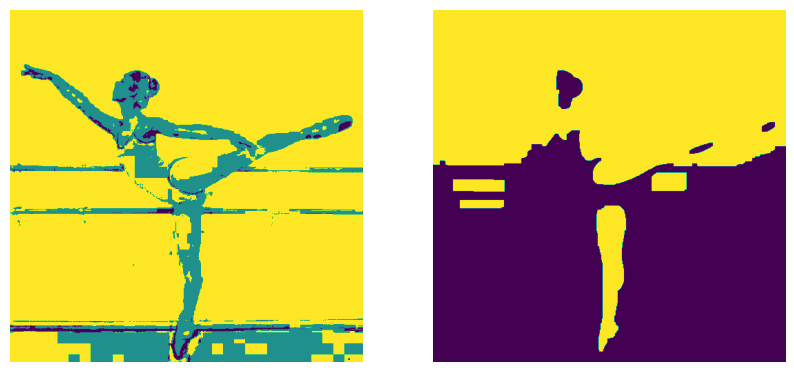

In [10]:
#pymaxflow

for lambd in [1e-2,1e-1,1]:
  print("")
  print("lambda : ", lambd)

  smooth_term = lambd * (1 - np.eye(n_clusters))
  data_term = distance_array.transpose(1,2,0).copy().astype(np.double)

  t1 = perf_counter()
  labels = aexpansion_grid(data_term, smooth_term, max_cycles=None)
  t2 = perf_counter()
  print(f"Done in {(t2-t1)} s")

  plot_2_images(greedy_assignments, labels)

In [11]:
#various graph cuts methods for our own alpha expanson
lambd = 1e-1
max_cycles = 10

for method in ["default","shortest_path","igraph"]:
  print("")
  print("method : ", method)

  assignments, energies, computed_energies = gc.alpha_expansion(distance_array.transpose(1,2,0), greedy_assignments, max_cycles=3, lambd=lambd, method=method)

  plot_2_images(greedy_assignments, assignments)
  gc.plot_energy(energies, computed_energies)


method :  default


  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Style transfer onf RGB space

[(9329, 3), (2924, 3), (4131, 3)]


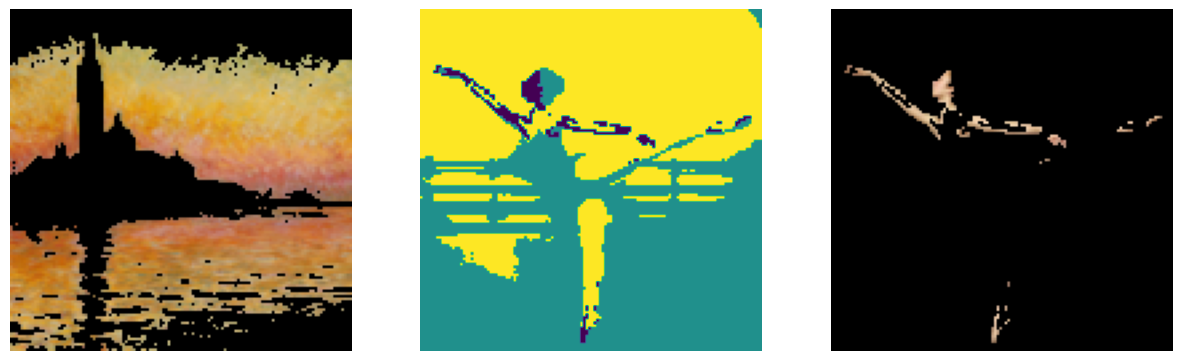

In [ ]:
cluster_list = [style_img[cluster_labels == i] for i in range(n_clusters)]
print([cluster_list[i].shape for i in range(n_clusters)])

cluster_0_style_mask = (cluster_labels == 0)
cluster_0_content_mask = (greedy_assignments == 0)

plot_3_images((style_img.transpose(2,0,1) * cluster_0_style_mask).transpose(1,2,0), greedy_assignments,(content_img.transpose(2,0,1) * cluster_0_content_mask).transpose(1,2,0))


Distance :  cosine
Transfered features shape :  torch.Size([3, 128, 128])


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


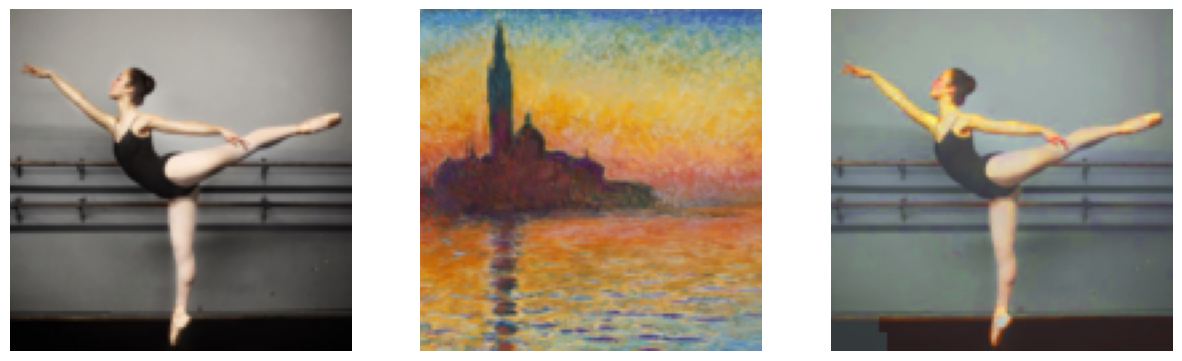


Distance :  euclidean


Transfered features shape :  torch.Size([3, 128, 128])


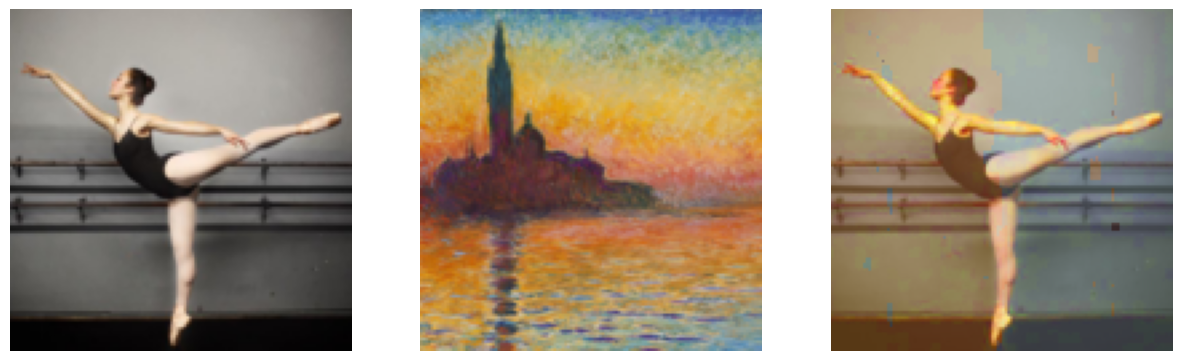

In [ ]:
#pymaxflow with euclidiean dist

for distance in ["cosine","euclidean"]:
  print("")
  print("Distance : ",distance)
  transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=0.5, lambd=0.1, k=3, distance=distance)
  print("Transfered features shape : ",transfered_features.shape)
  plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())

bon ça se remet à pas marcher lol mais dtf on change le repo donc balec

In [ ]:
#pymaxflow with different alphas
for alpha in [0.1,0.2,0.5,0.8,1]:
  print("")
  print("Alpha : ",alpha)
  transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=alpha, lambd=0.1, k=3)
  print("Transfered features shape : ",transfered_features.shape)
  plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())

Output hidden; open in https://colab.research.google.com to view.

## Using feature encoding